In [1]:
import pickle
import os
import gc
import numpy as np
from collections import defaultdict
from sklearn.cluster import KMeans, Birch
from scipy import stats
from scipy.spatial.distance import cdist
from scipy.stats import ttest_ind, mannwhitneyu, shapiro
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from scipy.spatial.distance import pdist, squareform
from scipy.spatial.distance import cosine, euclidean
from scipy.stats import rankdata
import matplotlib.pyplot as plt
import math
from sklearn.metrics import homogeneity_score
from scipy.stats import entropy
from scipy.spatial import ConvexHull
from matplotlib.patches import Ellipse
from sklearn.cluster import DBSCAN
import random
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr
import seaborn as sns
from sklearn.cluster import KMeans
from collections import defaultdict
from matplotlib.animation import FuncAnimation
from scipy.stats import kruskal
from scipy.stats import f_oneway, kruskal
from fairis_tools.experiment_tools.place_cell.PlaceCellLibrary import *
from tqdm import tqdm

In [2]:
os.chdir("../../..")
print(os.getcwd())

/Users/titonka/FAIRIS


In [10]:
modes = ['nearest_same_orientation','nearest_different_orientation', 'farthest_same_orientation', 'farthest_different_orientation']
thetas = [0.0, 0.7853981633974483, 1.5707963267948966, 2.356194490192345, 3.141592653589793, 3.9269908169872414, 4.71238898038469, 5.497787143782138]
landmarks = [
    (1.85, 1.85, (1.00, 0.00, 0.00)),
    (0.00, 2.61, (0.00, 1.00, 0.00)),
    (-1.85, 1.85, (0.00, 0.00, 1.00)),
    (-2.61, 0.00, (1.00, 1.00, 0.00)),
    (-2.61, 0.00, (1.00, 0.00, 1.00)),
    (-1.85, -1.85, (0.00, 1.00, 1.00)),
    (0.00, -2.61, (1.00, 0.50, 0.00)),
    (1.85, -1.85, (0.50, 0.00, 0.50)),
    (2.61, 0.00, (0.50, 0.50, 0.00))
]

LMO8_walls = [
    ((0.75, -1.25), (-0.75, -1.25)),  # Wall 1
    ((0.75, 1.25), (-0.75, 1.25)),    # Wall 2
    ((1.25, 0.75), (1.25, -0.75)),    # Wall 3
    ((-1.25, 0.75), (-1.25, -0.75)),  # Wall 4
    ((0.50, -0.50), (-0.50, 0.50)),   # Wall 5
    ((-0.50, -0.50), (0.50, 0.50))    # Wall 6
]
LM8_walls = []
LM8_add_walls = [
    ((0.75, -1.25), (-0.75, -1.25)),  # Wall 1
]
LMO8_remove_walls = [
    ((0.75, 1.25), (-0.75, 1.25)),    # Wall 2
    ((1.25, 0.75), (1.25, -0.75)),    # Wall 3
    ((-1.25, 0.75), (-1.25, -0.75)),  # Wall 4
    ((0.50, -0.50), (-0.50, 0.50)),   # Wall 5
    ((-0.50, -0.50), (0.50, 0.50))    # Wall 6
]

In [5]:
def group_dataset_by_theta(dataset):
    """
    Groups observations in the dataset by unique theta values. This function
    does not consider spatial proximity (x, y coordinates) during grouping.

    Parameters:
    - dataset: An object with an 'observations' attribute, which is a list of observations.
               Each observation is expected to have a 'theta' attribute.

    Returns:
    - dict: A dictionary where the keys are unique theta values, and the values are
            lists of observations corresponding to each theta.
    """
    # Initialize a dictionary to store the grouped observations by theta
    theta_groups = defaultdict(list)

    # Iterate through the observations and group them by their theta value
    for observation in dataset.observations:
        theta_groups[observation.theta].append(observation)

    return theta_groups
def group_dataset_for_wall_comparison(dataset, walls):
    """
    Groups the dataset by wall, side, and theta for comparison.

    Parameters:
    - dataset: An object with an 'observations' attribute, which is a list of observations.
               Each observation should have 'x', 'y', and 'theta' attributes.
    - walls: List of tuples representing walls. Each tuple is ((x1, y1), (x2, y2)).

    Returns:
    - dict: A nested dictionary structured as:
        {
            wall_number: {
                'side_1': {
                    theta: [points]
                },
                'side_2': {
                    theta: [points]
                }
            }
        }
    """
    grouped_data = defaultdict(lambda: {
        'side_1': defaultdict(list),
        'side_2': defaultdict(list)
    })

    # Group by theta using the existing function
    theta_groups = group_dataset_by_theta(dataset)

    # Handle all walls consistently (including walls 5 and 6)
    for wall_num, ((x1, y1), (x2, y2)) in enumerate(walls, start=1):
        for theta, points in theta_groups.items():
            # Number of points to select per side:
            if wall_num <= 4:
                num_points_per_side = 3
            else:
                num_points_per_side = 2

            # Calculate the distance of each point to the wall
            side_1_candidates = []
            side_2_candidates = []

            for point in points:
                a = y2 - y1
                b = x1 - x2
                c = x2 * y1 - x1 * y2
                side_value = a * point.x + b * point.y + c

                # Compute perpendicular distance to the wall
                distance = abs(a * point.x + b * point.y + c) / np.sqrt(a**2 + b**2)

                if side_value > 0:
                    side_1_candidates.append((point, distance))
                else:
                    side_2_candidates.append((point, distance))

            # Sort by distance and take the closest points
            side_1_candidates = sorted(side_1_candidates, key=lambda x: x[1])[:num_points_per_side]
            side_2_candidates = sorted(side_2_candidates, key=lambda x: x[1])[:num_points_per_side]

            # Add to grouped data
            for point, _ in side_1_candidates:
                grouped_data[f'wall_{wall_num}']['side_1'][theta].append(point)
            for point, _ in side_2_candidates:
                grouped_data[f'wall_{wall_num}']['side_2'][theta].append(point)

    return grouped_data
def plot_split_data(grouped_data, walls, landmarks, theta):
    """
    Plots the split data into subplots, one for each wall, including walls, landmarks, and side data.

    Parameters:
    - grouped_data: Nested dictionary with structure {wall -> side -> theta -> points}.
    - walls: List of tuples representing walls. Each tuple is ((x1, y1), (x2, y2)).
    - landmarks: List of tuples representing landmarks with format (x, y, (r, g, b)).
    - theta: Fixed theta value to plot points for.
    """
    num_walls = len(walls)
    num_cols = 3
    num_rows = (num_walls + num_cols - 1) // num_cols
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
    axes = axes.flatten()

    # Sort landmarks based on their angle from the center (to create an octagon)
    landmark_positions = [(x, y) for (x, y, _) in landmarks]
    landmark_positions.sort(key=lambda p: np.arctan2(p[1], p[0]))

    # Step 1: Loop over each wall
    for i, ((x1, y1), (x2, y2)) in enumerate(walls):
        ax = axes[i]
        
        # Step 2: Plot the landmarks
        for (x, y, (r, g, b)) in landmarks:
            ax.scatter(x, y, color=(r, g, b), s=80, edgecolor='black')
        
        # Draw the octagon by connecting adjacent landmarks
        for j in range(len(landmark_positions)):
            x_start, y_start = landmark_positions[j]
            x_end, y_end = landmark_positions[(j + 1) % len(landmark_positions)]  # Wrap around to close the shape
            ax.plot([x_start, x_end], [y_start, y_end], color='gray', linewidth=1)

        # Step 3: Plot all walls in gray, highlight the active wall in red
        for j, ((wx1, wy1), (wx2, wy2)) in enumerate(walls):
            color = 'gray' if i != j else 'red'
            ax.plot([wx1, wx2], [wy1, wy2], color=color, linewidth=2)

        # Step 4: Plot the data points for the current wall
        wall_key = f'wall_{i + 1}'
        if wall_key in grouped_data:
            if 'side_1' in grouped_data[wall_key] and theta in grouped_data[wall_key]['side_1']:
                side_1_points = grouped_data[wall_key]['side_1'][theta]
                x_side_1 = [p.x for p in side_1_points]
                y_side_1 = [p.y for p in side_1_points]
                ax.scatter(x_side_1, y_side_1, color='blue', label='Side 1', s=30)

            if 'side_2' in grouped_data[wall_key] and theta in grouped_data[wall_key]['side_2']:
                side_2_points = grouped_data[wall_key]['side_2'][theta]
                x_side_2 = [p.x for p in side_2_points]
                y_side_2 = [p.y for p in side_2_points]
                ax.scatter(x_side_2, y_side_2, color='green', label='Side 2', s=30)

        # Set plot limits and labels
        ax.set_xlim(-2.7, 2.7)
        ax.set_ylim(-2.7, 2.7)
        ax.set_title(f'Wall {i + 1}')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.legend()

    plt.tight_layout()
    plt.show()


In [6]:
def calculate_and_visualize_wall_similarity(grouped_data, pc_network, wall_num, theta_index, landmarks, walls):
    """
    Calculate and visualize similarity metrics for place cell activations from points on both sides of a specific wall.

    Parameters:
    - grouped_data: dict, structured wall data from grouping function.
    - pc_network: object, place cell network for activation calculation.
    - wall_num: int, wall number to analyze.
    - theta: float, fixed theta value to select points from.
    - landmarks: list of tuples [(x, y, (r, g, b))], coordinates and colors of landmarks.
    - walls: list of tuples representing walls [(x1, y1), (x2, y2)].

    Returns:
    - None, but displays the combined visualization.
    """
    wall_key = f'wall_{wall_num}'
    if wall_key not in grouped_data:
        raise ValueError(f"Wall {wall_num} not found in the data")
    thetas = [0.0, 0.7853981633974483, 1.5707963267948966, 2.356194490192345, 3.141592653589793, 3.9269908169872414, 4.71238898038469, 5.497787143782138]
    theta = thetas[theta_index]
    side_1_points = grouped_data[wall_key]['side_1'].get(theta, [])
    side_2_points = grouped_data[wall_key]['side_2'].get(theta, [])

    num_points = len(side_1_points) + len(side_2_points)

    if num_points == 0:
        raise ValueError(f"No data points available for wall {wall_num} at theta {theta}")

    # Step 1: Create layout (square layout)
    num_cols = 4
    num_rows = max(3, (num_points + num_cols - 1) // num_cols) + 2  # Add room for heatmaps

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))
    axes = axes.flatten()

    # Step 2: Spatial plot
    spatial_ax = axes[0]

    # Plot the landmarks
    landmark_positions = [(x, y) for (x, y, _) in landmarks]
    landmark_positions.sort(key=lambda p: np.arctan2(p[1], p[0]))
    for (x, y, (r, g, b)) in landmarks:
        spatial_ax.scatter(x, y, color=(r, g, b), s=80, edgecolor='black')
    
    # Draw octagon connecting the landmarks
    for i in range(len(landmark_positions)):
        x1, y1 = landmark_positions[i]
        x2, y2 = landmark_positions[(i + 1) % len(landmark_positions)]
        spatial_ax.plot([x1, x2], [y1, y2], color='black', linewidth=1)

    # Plot all walls in gray, highlight the current wall in red
    for i, ((x1, y1), (x2, y2)) in enumerate(walls):
        color = 'gray' if i + 1 != wall_num else 'red'
        spatial_ax.plot([x1, x2], [y1, y2], color=color, linewidth=2)

    # Plot side 1 points in blue with orientation vector
    for p in side_1_points:
        spatial_ax.scatter(p.x, p.y, color='blue', label='Side 1', s=30)
        # theta_rad = np.deg2rad(p.theta)
        dx = 0.3 * np.cos(p.theta)
        dy = 0.3 * np.sin(p.theta)
        spatial_ax.arrow(p.x, p.y, dx, dy, head_width=0.1, head_length=0.1, fc='blue', ec='blue')

    # Plot side 2 points in green with orientation vector
    for p in side_2_points:
        spatial_ax.scatter(p.x, p.y, color='green', label='Side 2', s=30)
        # theta_rad = np.deg2rad(p.theta)
        dx = 0.3 * np.cos(p.theta)
        dy = 0.3 * np.sin(p.theta)
        spatial_ax.arrow(p.x, p.y, dx, dy, head_width=0.1, head_length=0.1, fc='green', ec='green')

    spatial_ax.set_xlim([-2.7, 2.7])
    spatial_ax.set_ylim([-2.7, 2.7])
    spatial_ax.set_title(f"Wall {wall_num} - Spatial Layout")
    spatial_ax.set_xlabel("X")
    spatial_ax.set_ylabel("Y")

    # Step 3: Calculate similarity metrics
    all_points = side_1_points + side_2_points
    activation_vectors = []
    
    for p in all_points:
        activations = pc_network.get_all_pc_activations_normalized(p.multimodal_feature_vector, norm_type='min_max')
        activation_vectors.append(activations)

    activation_vectors = np.array(activation_vectors)

    # Cosine similarity, Pearson correlation, Euclidean distance
    cosine_sim_matrix = 1 - squareform(pdist(activation_vectors, metric='cosine'))
    euclidean_dist_matrix = squareform(pdist(activation_vectors, metric='euclidean'))
    n = len(pc_network.pc_list)
    euclidean_scale = np.sqrt(n)

    pearson_corr_matrix = np.zeros((len(activation_vectors), len(activation_vectors)))
    for i in range(len(activation_vectors)):
        for j in range(len(activation_vectors)):
            if i != j:
                pearson_corr_matrix[i, j], _ = pearsonr(activation_vectors[i], activation_vectors[j])
            else:
                pearson_corr_matrix[i, j] = 1

    # Step 4: Plot similarity heatmaps
    heatmap_titles = ['Cosine Similarity', 'Pearson Correlation', 'Euclidean Distance']
    similarity_matrices = [cosine_sim_matrix, pearson_corr_matrix, euclidean_dist_matrix]
    heatmap_scales = [(0, 1), (0, 1), (0, euclidean_scale)]

    for idx, (matrix, title, scale) in enumerate(zip(similarity_matrices, heatmap_titles, heatmap_scales)):
        ax = axes[idx + 1]
        sns.heatmap(matrix, ax=ax, cmap='viridis', annot=True, vmin=scale[0], vmax=scale[1])
        ax.set_title(title)
        ax.set_xlabel('Data Point Index')
        ax.set_ylabel('Data Point Index')

        # Add a divider to indicate side 1 vs side 2
        if len(side_1_points) > 0 and len(side_2_points) > 0:
            ax.axhline(len(side_1_points), color='red', lw=2)
            ax.axvline(len(side_1_points), color='red', lw=2)

    # Step 5: Activation plots
    for i, activations in enumerate(activation_vectors):
        ax = axes[len(similarity_matrices) + i + 1]
        ax.bar(range(len(activations)), activations, color='orange')
        ax.set_title(f'PC Activations (Data Point {i + 1})')
        ax.set_xlabel('Place Cell Index')
        ax.set_ylabel('Activation')

    # Remove any unused axes
    for i in range(len(similarity_matrices) + num_points + 1, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

In [7]:
def visualize_wall_similarity(grouped_data, pc_network, wall_num, theta_list, landmarks, walls):
    """
    Visualize similarity metrics for place cell activations across different theta values.

    Parameters:
    - grouped_data: dict, structured wall data from grouping function.
    - pc_network: object, place cell network for activation calculation.
    - wall_num: int, wall number to analyze.
    - theta_list: list of float, theta values to visualize.
    - landmarks: list of tuples [(x, y, (r, g, b))], coordinates and colors of landmarks.
    - walls: list of tuples representing walls [(x1, y1), (x2, y2)].

    Returns:
    - None, but displays the combined visualization.
    """
    wall_key = f'wall_{wall_num}'
    if wall_key not in grouped_data:
        raise ValueError(f"Wall {wall_num} not found in the data")

    num_thetas = len(theta_list)
    num_cols = 4
    num_rows = num_thetas

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
    fig.suptitle(f"Wall {wall_num} - Similarity Metrics Across Thetas", fontsize=16)

    for row, theta in enumerate(theta_list):
        side_1_points = grouped_data[wall_key]['side_1'].get(theta, [])
        side_2_points = grouped_data[wall_key]['side_2'].get(theta, [])

        num_points = len(side_1_points) + len(side_2_points)
        if num_points == 0:
            continue

        # Step 1: Spatial Plot
        ax = axes[row, 0]
        landmark_positions = [(x, y) for (x, y, _) in landmarks]
        landmark_positions.sort(key=lambda p: np.arctan2(p[1], p[0]))

        for (x, y, (r, g, b)) in landmarks:
            ax.scatter(x, y, color=(r, g, b), s=80, edgecolor='black')

        # Connect landmarks to form an octagon
        for i in range(len(landmark_positions)):
            x1, y1 = landmark_positions[i]
            x2, y2 = landmark_positions[(i + 1) % len(landmark_positions)]
            ax.plot([x1, x2], [y1, y2], color='black', linewidth=1)

        # Plot walls
        for i, ((x1, y1), (x2, y2)) in enumerate(walls):
            color = 'gray' if i + 1 != wall_num else 'red'
            ax.plot([x1, x2], [y1, y2], color=color, linewidth=2)

        # Plot data points and orientation
        for p in side_1_points:
            ax.scatter(p.x, p.y, color='blue', label='Side 1', s=30)
            dx = 0.3 * np.cos(p.theta)
            dy = 0.3 * np.sin(p.theta)
            ax.arrow(p.x, p.y, dx, dy, head_width=0.1, head_length=0.1, fc='blue', ec='blue')

        for p in side_2_points:
            ax.scatter(p.x, p.y, color='green', label='Side 2', s=30)
            dx = 0.3 * np.cos(p.theta)
            dy = 0.3 * np.sin(p.theta)
            ax.arrow(p.x, p.y, dx, dy, head_width=0.1, head_length=0.1, fc='green', ec='green')

        ax.set_xlim([-2.7, 2.7])
        ax.set_ylim([-2.7, 2.7])
        ax.set_title(f'Theta: {theta:.2f} - Spatial Plot')

        # Step 2: Calculate similarity metrics
        all_points = side_1_points + side_2_points
        activation_vectors = [pc_network.get_all_pc_activations_normalized(p.multimodal_feature_vector, norm_type='min_max')
                              for p in all_points]

        activation_vectors = np.array(activation_vectors)

        cosine_sim_matrix = 1 - squareform(pdist(activation_vectors, metric='cosine'))
        euclidean_dist_matrix = squareform(pdist(activation_vectors, metric='euclidean'))
        n = len(pc_network.pc_list)
        euclidean_scale = np.sqrt(n)

        pearson_corr_matrix = np.zeros((len(activation_vectors), len(activation_vectors)))
        for i in range(len(activation_vectors)):
            for j in range(len(activation_vectors)):
                if i != j:
                    pearson_corr_matrix[i, j], _ = pearsonr(activation_vectors[i], activation_vectors[j])
                else:
                    pearson_corr_matrix[i, j] = 1

        # Step 3: Cosine Similarity Heatmap
        ax = axes[row, 1]
        sns.heatmap(cosine_sim_matrix, ax=ax, cmap='viridis', annot=True, vmin=0, vmax=1)
        ax.set_title('Cosine Similarity')

        # Step 4: Pearson Correlation Heatmap
        ax = axes[row, 2]
        sns.heatmap(pearson_corr_matrix, ax=ax, cmap='viridis', annot=True, vmin=0, vmax=1)
        ax.set_title('Pearson Correlation')

        # Step 5: Euclidean Distance Heatmap
        ax = axes[row, 3]
        sns.heatmap(euclidean_dist_matrix, ax=ax, cmap='viridis', annot=True, vmin=0, vmax=euclidean_scale)
        ax.set_title('Euclidean Distance')

        # Draw red lines to distinguish sides
        if len(side_1_points) > 0 and len(side_2_points) > 0:
            for ax in [axes[row, 1], axes[row, 2], axes[row, 3]]:
                ax.axhline(len(side_1_points), color='red', lw=2)
                ax.axvline(len(side_1_points), color='red', lw=2)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Example call:
# theta_list = [0.0, 1.5708, 3.1416]
# visualize_wall_similarity(grouped_data, pc_network, wall_num=1, theta_list=theta_list, landmarks=landmarks, walls=walls)


In [54]:
def calculate_similarity_metrics(activation_1, activation_2):
    """
    Calculate similarity metrics between two place cell activation vectors.

    Parameters:
    - activation_1: np.array, first place cell activation vector.
    - activation_2: np.array, second place cell activation vector.

    Returns:
    - cos_sim: float, cosine similarity between activation_1 and activation_2.
    - pearson_corr: float, Pearson correlation coefficient between activation_1 and activation_2.
    - dist: float, Euclidean distance between activation_1 and activation_2.
    """
    # Cosine similarity (1 - cosine distance because higher value means more similar)
    cos_sim = 1 - cosine(activation_1, activation_2)

    # Pearson correlation (returns NaN if the variance of either vector is zero)
    try:
        pearson_corr, _ = pearsonr(activation_1, activation_2)
    except Exception:
        pearson_corr = np.nan

    # Euclidean distance
    dist = euclidean(activation_1, activation_2)

    return cos_sim, pearson_corr, dist

def collect_wall_similarity_metrics(grouped_data, pc_network):
    """
    Collect similarity metrics for data points on both sides of Wall 1.

    Parameters:
    - grouped_data: dict, data structured as {wall: {side: {theta: [data points]}}}
    - pc_network: object, the place cell network used to get activations.

    Returns:
    - same_side_metrics: list of (cos_sim, pearson_corr, dist) for same-side pairs.
    - diff_side_metrics: list of (cos_sim, pearson_corr, dist) for different-side pairs.
    """
    same_side_metrics = []
    diff_side_metrics = []

    wall_key = 'wall_1'  # Focus only on Wall 1

    if wall_key not in grouped_data:
        raise ValueError(f"{wall_key} not found in the grouped data.")

    side_1_points = grouped_data[wall_key]['side_1']
    side_2_points = grouped_data[wall_key]['side_2']

    total_comparisons = 120

    with tqdm(total=total_comparisons, desc="Calculating Similarity for Wall 1") as pbar:
        for theta in side_1_points.keys():
            if theta not in side_2_points:
                continue

            points_side_1 = side_1_points[theta]
            points_side_2 = side_2_points[theta]

            # Compare all pairs within side 1
            for i in range(len(points_side_1)):
                for j in range(i + 1, len(points_side_1)):
                    activation_1 = pc_network.get_all_pc_activations_normalized(
                        points_side_1[i].multimodal_feature_vector, norm_type='min_max'
                    )
                    activation_2 = pc_network.get_all_pc_activations_normalized(
                        points_side_1[j].multimodal_feature_vector, norm_type='min_max'
                    )
                    same_side_metrics.append(calculate_similarity_metrics(activation_1, activation_2))
                    pbar.update(1)

            # Compare all pairs within side 2
            for i in range(len(points_side_2)):
                for j in range(i + 1, len(points_side_2)):
                    activation_1 = pc_network.get_all_pc_activations_normalized(
                        points_side_2[i].multimodal_feature_vector, norm_type='min_max'
                    )
                    activation_2 = pc_network.get_all_pc_activations_normalized(
                        points_side_2[j].multimodal_feature_vector, norm_type='min_max'
                    )
                    same_side_metrics.append(calculate_similarity_metrics(activation_1, activation_2))
                    pbar.update(1)

            # Compare pairs across side 1 and side 2 (same theta)
            for i in range(len(points_side_1)):
                for j in range(len(points_side_2)):
                    activation_1 = pc_network.get_all_pc_activations_normalized(
                        points_side_1[i].multimodal_feature_vector, norm_type='min_max'
                    )
                    activation_2 = pc_network.get_all_pc_activations_normalized(
                        points_side_2[j].multimodal_feature_vector, norm_type='min_max'
                    )
                    diff_side_metrics.append(calculate_similarity_metrics(activation_1, activation_2))
                    pbar.update(1)

    return same_side_metrics, diff_side_metrics


def plot_wall_similarity_metrics(same_side_metrics, diff_side_metrics, title):
    """
    Create box plots for Cosine Similarity and Euclidean Distance for Wall 1.

    Parameters:
    - same_side_metrics: list of (cos_sim, pearson_corr, dist) for same-side pairs.
    - diff_side_metrics: list of (cos_sim, pearson_corr, dist) for different-side pairs.
    - title: str, title of the plot.

    Returns:
    - None, but shows box plots.
    """
    # Separate the metrics
    same_side_cos_sim = [x[0] for x in same_side_metrics]
    diff_side_cos_sim = [x[0] for x in diff_side_metrics]
    same_side_dist = [x[2] for x in same_side_metrics]
    diff_side_dist = [x[2] for x in diff_side_metrics]

    # Create a dataframe for easier plotting
    data = {
        'Cosine Similarity': same_side_cos_sim + diff_side_cos_sim,
        'Euclidean Distance': same_side_dist + diff_side_dist,
        'Type': (['Same Side'] * len(same_side_cos_sim)) + (['Different Side'] * len(diff_side_cos_sim))
    }

    fig, axes = plt.subplots(1, 2, figsize=(6, 6))
    fig.suptitle(title)

    # Plot boxplots for Cosine Similarity
    sns.boxplot(x='Type', y='Cosine Similarity', hue='Type', data=data, ax=axes[0], palette='Set2', legend=False)
    axes[0].set_title('Cosine Similarity')
    axes[0].set_ylabel('Cosine Similarity')

    # Plot boxplots for Euclidean Distance
    sns.boxplot(x='Type', y='Euclidean Distance', hue='Type', data=data, ax=axes[1], palette='Set2', legend=False)
    axes[1].set_title('Euclidean Distance')
    axes[1].set_ylabel('Euclidean Distance')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



def compute_effect_sizes(same_side_metrics, diff_side_metrics):
    """
    Compute Mann-Whitney U test, rank-biserial correlation, and Cohen's d
    for both Cosine Similarity and Euclidean Distance.

    Parameters:
    - same_side_metrics: List of tuples (cosine_sim, pearson_corr, euclidean_dist) for same-side pairs.
    - diff_side_metrics: List of tuples (cosine_sim, pearson_corr, euclidean_dist) for different-side pairs.

    Returns:
    - dict: Results for cosine similarity and euclidean distance.
    """
    # Extract cosine similarity and distance values
    same_side_cosine = [m[0] for m in same_side_metrics]
    diff_side_cosine = [m[0] for m in diff_side_metrics]
    
    same_side_dist = [m[2] for m in same_side_metrics]
    diff_side_dist = [m[2] for m in diff_side_metrics]

    results = {}

    # Cosine Similarity Analysis
    u_stat, p_value = mannwhitneyu(same_side_cosine, diff_side_cosine, alternative='greater')
    rank_biserial_corr = (2 * u_stat) / (len(same_side_cosine) * len(diff_side_cosine)) - 1
    cohen_d = (np.mean(same_side_cosine) - np.mean(diff_side_cosine)) / np.sqrt(
        (np.std(same_side_cosine, ddof=1) ** 2 + np.std(diff_side_cosine, ddof=1) ** 2) / 2)

    results['cosine_similarity'] = {
        'u_statistic': u_stat,
        'p_value': p_value,
        'rank_biserial_corr': rank_biserial_corr,
        'cohen_d': cohen_d
    }

    # Euclidean Distance Analysis
    u_stat_dist, p_value_dist = mannwhitneyu(same_side_dist, diff_side_dist, alternative='less')
    rank_biserial_corr_dist = (2 * u_stat_dist) / (len(same_side_dist) * len(diff_side_dist)) - 1
    cohen_d_dist = (np.mean(same_side_dist) - np.mean(diff_side_dist)) / np.sqrt(
        (np.std(same_side_dist, ddof=1) ** 2 + np.std(diff_side_dist, ddof=1) ** 2) / 2)

    results['euclidean_distance'] = {
        'u_statistic': u_stat_dist,
        'p_value': p_value_dist,
        'rank_biserial_corr': rank_biserial_corr_dist,
        'cohen_d': cohen_d_dist
    }

    return results

In [34]:
def collect_matching_pairs(before_grouped_data, after_grouped_data, pc_network):
    """
    Collect similarity metrics for data points at the same (x, y, theta) before and after wall changes.

    Parameters:
    - before_grouped_data: dict, data points before wall change.
    - after_grouped_data: dict, data points after wall change.
    - pc_network: object, place cell network used to calculate activations.

    Returns:
    - paired_metrics: list of (cos_sim, pearson_corr, dist) for matched pairs.
    """
    paired_metrics = []
    
    wall_key = 'wall_1'  # Focus ONLY on Wall 1
    if wall_key not in before_grouped_data or wall_key not in after_grouped_data:
        raise ValueError(f"{wall_key} not found in the grouped data.")

    total_comparisons = sum(
        len(before_grouped_data[wall_key][side][theta])
        for side in before_grouped_data[wall_key]
        for theta in before_grouped_data[wall_key][side]
        if side in after_grouped_data[wall_key] and theta in after_grouped_data[wall_key][side]
    )

    with tqdm(total=total_comparisons, desc="Collecting Matching Pairs for Wall 1") as pbar:
        for side in before_grouped_data[wall_key]:
            if side not in after_grouped_data[wall_key]:
                continue

            for theta in before_grouped_data[wall_key][side]:
                if theta not in after_grouped_data[wall_key][side]:
                    continue

                before_points = before_grouped_data[wall_key][side][theta]
                after_points = after_grouped_data[wall_key][side][theta]

                # Match by (x, y) position
                before_points_dict = {(p.x, p.y): p for p in before_points}
                after_points_dict = {(p.x, p.y): p for p in after_points}

                common_positions = set(before_points_dict.keys()) & set(after_points_dict.keys())

                for pos in common_positions:
                    before_p = before_points_dict[pos]
                    after_p = after_points_dict[pos]

                    activation_before = pc_network.get_all_pc_activations_normalized(
                        before_p.multimodal_feature_vector, norm_type='min_max'
                    )
                    activation_after = pc_network.get_all_pc_activations_normalized(
                        after_p.multimodal_feature_vector, norm_type='min_max'
                    )

                    paired_metrics.append(calculate_similarity_metrics(activation_before, activation_after))
                    pbar.update(1)

    return paired_metrics


def compute_effect_sizes_paired(paired_metrics):
    """
    Compute rank-biserial correlation and Cohen's d for paired data.

    Parameters:
    - paired_metrics: list of (cos_sim, pearson_corr, dist) for matched pairs.

    Returns:
    - dict: Results for cosine similarity and euclidean distance.
    """
    # Separate metrics
    cosine_sim = [x[0] for x in paired_metrics]
    euclidean_dist = [x[2] for x in paired_metrics]

    results = {}

    # Cosine Similarity Analysis
    u_stat, p_value = mannwhitneyu(cosine_sim, euclidean_dist, alternative='greater')
    rank_biserial_corr = (2 * u_stat) / (len(cosine_sim) * len(euclidean_dist)) - 1
    cohen_d = (np.mean(cosine_sim) - np.mean(euclidean_dist)) / np.sqrt(
        (np.std(cosine_sim, ddof=1) ** 2 + np.std(euclidean_dist, ddof=1) ** 2) / 2
    )

    results['cosine_similarity'] = {
        'u_statistic': u_stat,
        'p_value': p_value,
        'rank_biserial_corr': rank_biserial_corr,
        'cohen_d': cohen_d
    }

    # Euclidean Distance Analysis
    u_stat_dist, p_value_dist = mannwhitneyu(euclidean_dist, cosine_sim, alternative='less')
    rank_biserial_corr_dist = (2 * u_stat_dist) / (len(euclidean_dist) * len(cosine_sim)) - 1
    cohen_d_dist = (np.mean(euclidean_dist) - np.mean(cosine_sim)) / np.sqrt(
        (np.std(euclidean_dist, ddof=1) ** 2 + np.std(cosine_sim, ddof=1) ** 2) / 2
    )

    results['euclidean_distance'] = {
        'u_statistic': u_stat_dist,
        'p_value': p_value_dist,
        'rank_biserial_corr': rank_biserial_corr_dist,
        'cohen_d': cohen_d_dist
    }

    return results



In [41]:
def plot_matching_pairs(grouped_data_before, grouped_data_after, pc_network, theta, landmarks, walls):
    """
    Create a plot showing data point location, orientation, place cell activation (before/after), 
    and the difference between them.

    Parameters:
    - grouped_data_before: dict, data before wall change.
    - grouped_data_after: dict, data after wall change.
    - pc_network: object, place cell network.
    - theta: float, orientation to match.
    - landmarks: list of tuples [(x, y, (r, g, b))].
    - walls: list of tuples [(x1, y1), (x2, y2)].
    """
    wall_key = 'wall_1'  # Focus only on Wall 1

    if wall_key not in grouped_data_before or wall_key not in grouped_data_after:
        raise ValueError(f"{wall_key} not found in grouped data.")

    side_1_before = grouped_data_before[wall_key]['side_1'].get(theta, [])
    side_1_after = grouped_data_after[wall_key]['side_1'].get(theta, [])

    side_2_before = grouped_data_before[wall_key]['side_2'].get(theta, [])
    side_2_after = grouped_data_after[wall_key]['side_2'].get(theta, [])

    # Match by (x, y) position
    before_points = { (p.x, p.y): p for p in side_1_before + side_2_before }
    after_points = { (p.x, p.y): p for p in side_1_after + side_2_after }
    
    matched_positions = set(before_points.keys()) & set(after_points.keys())

    num_rows = len(matched_positions)
    num_cols = 4
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 4 * num_rows))
    fig.suptitle(f'Matched Data Points for Theta = {theta:.2f}', fontsize=16)

    for row, pos in enumerate(matched_positions):
        before_p = before_points[pos]
        after_p = after_points[pos]

        # Step 1: Spatial Plot
        ax = axes[row, 0]
        ax.set_xlim([-2.7, 2.7])
        ax.set_ylim([-2.7, 2.7])

        # Plot landmarks
        for x, y, (r, g, b) in landmarks:
            ax.scatter(x, y, color=(r, g, b), s=80, edgecolor='black', zorder=10)

        # Connect adjacent landmarks to form boundaries
        landmark_positions = [(x, y) for (x, y, _) in landmarks]
        for i in range(len(landmark_positions)):
            x1, y1 = landmark_positions[i]
            x2, y2 = landmark_positions[(i + 1) % len(landmark_positions)]
            ax.plot([x1, x2], [y1, y2], color='black', linewidth=1)

        # Plot walls
        for (x1, y1), (x2, y2) in walls:
            ax.plot([x1, x2], [y1, y2], color='gray', linewidth=2)

        # Plot data point and orientation vector
        ax.scatter(before_p.x, before_p.y, color='blue', s=50)
        dx = 0.3 * np.cos(before_p.theta)
        dy = 0.3 * np.sin(before_p.theta)
        ax.arrow(before_p.x, before_p.y, dx, dy, head_width=0.1, head_length=0.1, fc='red', ec='red')

        ax.set_title(f"Data Point @ ({before_p.x:.2f}, {before_p.y:.2f})")

        # Step 2: Activation Plot (Before)
        ax = axes[row, 1]
        activation_before = pc_network.get_all_pc_activations_normalized(
            before_p.multimodal_feature_vector, norm_type='min_max'
        )
        ax.bar(range(len(activation_before)), activation_before, color='blue')
        ax.set_title("Activation (Before)")

        # Step 3: Activation Plot (After)
        ax = axes[row, 2]
        activation_after = pc_network.get_all_pc_activations_normalized(
            after_p.multimodal_feature_vector, norm_type='min_max'
        )
        ax.bar(range(len(activation_after)), activation_after, color='green')
        ax.set_title("Activation (After)")

        # Step 4: Difference Plot
        ax = axes[row, 3]
        difference = np.abs(activation_before - activation_after)
        ax.bar(range(len(difference)), difference, color='orange')
        ax.set_title("Difference (|Before - After|)")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [50]:
def visualize_multiple_wall_similarity(list_of_configs):
    """
    Visualize similarity metrics for place cell activations across different wall configurations.

    Parameters:
    - list_of_configs: list of lists where each element contains:
        [grouped_data, pc_network, wall_num, theta, landmarks, walls]

    Returns:
    - None, but displays the combined visualization.
    """
    num_rows = len(list_of_configs)
    num_cols = 4
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
    fig.suptitle("Comparison of Wall Configurations", fontsize=16)

    for row, config in enumerate(list_of_configs):
        grouped_data, pc_network, wall_num, theta, landmarks, walls = config

        wall_key = f'wall_{wall_num}'
        if wall_key not in grouped_data:
            raise ValueError(f"Wall {wall_num} not found in the grouped data")

        side_1_points = grouped_data[wall_key]['side_1'].get(theta, [])
        side_2_points = grouped_data[wall_key]['side_2'].get(theta, [])

        num_points = len(side_1_points) + len(side_2_points)
        if num_points == 0:
            continue

        # Step 1: Spatial Plot
        ax = axes[row, 0]
        ax.set_xlim([-2.7, 2.7])
        ax.set_ylim([-2.7, 2.7])

        # Plot landmarks
        landmark_positions = [(x, y) for (x, y, _) in landmarks]
        landmark_positions.sort(key=lambda p: np.arctan2(p[1], p[0]))

        for (x, y, (r, g, b)) in landmarks:
            ax.scatter(x, y, color=(r, g, b), s=80, edgecolor='black', zorder=10)

        # Connect landmarks to form an octagon
        for i in range(len(landmark_positions)):
            x1, y1 = landmark_positions[i]
            x2, y2 = landmark_positions[(i + 1) % len(landmark_positions)]
            ax.plot([x1, x2], [y1, y2], color='black', linewidth=1)

        # Plot walls
        for i, ((x1, y1), (x2, y2)) in enumerate(walls):
            color = 'gray' if i + 1 != wall_num or len(walls) == 5 else 'red'
            ax.plot([x1, x2], [y1, y2], color=color, linewidth=2)

        # Plot data points and orientation
        for p in side_1_points:
            ax.scatter(p.x, p.y, color='blue', label='Side 1', s=30)
            dx = 0.3 * np.cos(p.theta)
            dy = 0.3 * np.sin(p.theta)
            ax.arrow(p.x, p.y, dx, dy, head_width=0.1, head_length=0.1, fc='blue', ec='blue')

        for p in side_2_points:
            ax.scatter(p.x, p.y, color='green', label='Side 2', s=30)
            dx = 0.3 * np.cos(p.theta)
            dy = 0.3 * np.sin(p.theta)
            ax.arrow(p.x, p.y, dx, dy, head_width=0.1, head_length=0.1, fc='green', ec='green')

        ax.set_title(f'Wall {wall_num} - Theta: {theta:.2f}')

        # Step 2: Calculate similarity metrics
        all_points = side_1_points + side_2_points
        activation_vectors = [
            pc_network.get_all_pc_activations_normalized(p.multimodal_feature_vector, norm_type='min_max')
            for p in all_points
        ]

        activation_vectors = np.array(activation_vectors)

        # Cosine Similarity
        cosine_sim_matrix = 1 - squareform(pdist(activation_vectors, metric='cosine'))
        # Euclidean Distance
        euclidean_dist_matrix = squareform(pdist(activation_vectors, metric='euclidean'))
        n = len(pc_network.pc_list)
        euclidean_scale = np.sqrt(n)

        # Pearson Correlation
        pearson_corr_matrix = np.zeros((len(activation_vectors), len(activation_vectors)))
        for i in range(len(activation_vectors)):
            for j in range(len(activation_vectors)):
                if i != j:
                    pearson_corr_matrix[i, j], _ = pearsonr(activation_vectors[i], activation_vectors[j])
                else:
                    pearson_corr_matrix[i, j] = 1

        # Step 3: Cosine Similarity Heatmap
        ax = axes[row, 1]
        sns.heatmap(cosine_sim_matrix, ax=ax, cmap='viridis', annot=True, vmin=0, vmax=1)
        ax.set_title('Cosine Similarity')

        # Step 4: Pearson Correlation Heatmap
        ax = axes[row, 2]
        sns.heatmap(pearson_corr_matrix, ax=ax, cmap='viridis', annot=True, vmin=0, vmax=1)
        ax.set_title('Pearson Correlation')

        # Step 5: Euclidean Distance Heatmap
        ax = axes[row, 3]
        sns.heatmap(euclidean_dist_matrix, ax=ax, cmap='viridis', annot=True, vmin=0, vmax=euclidean_scale)
        ax.set_title('Euclidean Distance')

        # Draw dividing lines between sides
        if len(side_1_points) > 0 and len(side_2_points) > 0:
            for ax in [axes[row, 1], axes[row, 2], axes[row, 3]]:
                ax.axhline(len(side_1_points), color='red', lw=2)
                ax.axvline(len(side_1_points), color='red', lw=2)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Load PC Files


In [8]:
maze_files = ['LM4','LM6','LM8','LMO8','LM8_addition','LMO8_remove']
maze_index = 3
feature_mode = 'multimodal'
n = 100
file_name = feature_mode+'_kmeans_'+str(n)+"_"+maze_files[maze_index]
with open("data/VisualPlaceCellData/VisualPlaceCellClusters/"+file_name,'rb') as file:
    data = pickle.load(file)

pc_network_LMO8 = VisualPlaceCellNetwork()
for cluster in data:
    if cluster[1] != 0:
        pc_network_LMO8.add_pc_to_network(cluster[0],radius=cluster[1])
    else:
        pc_network_LMO8.add_pc_to_network(cluster[0],radius=1)
del data
out1 = gc.collect()

maze_index = 2
file_name = feature_mode+'_kmeans_'+str(n)+"_"+maze_files[maze_index]
with open("data/VisualPlaceCellData/VisualPlaceCellClusters/"+file_name,'rb') as file:
    data = pickle.load(file)

pc_network_LM8 = VisualPlaceCellNetwork()
for cluster in data:
    if cluster[1] != 0:
        pc_network_LM8.add_pc_to_network(cluster[0],radius=cluster[1])
    else:
        pc_network_LM8.add_pc_to_network(cluster[0],radius=1)
del data
out1 = gc.collect()

# Load Testing Data

In [9]:
with open("data/VisualPlaceCellData/LMO8_Testing_wall", 'rb') as file:
    LMO8_test_data = pickle.load(file)
with open("data/VisualPlaceCellData/LMO8_remove_base_Testing_wall", 'rb') as file:
    LMO8_remove_test_data = pickle.load(file)
with open("data/VisualPlaceCellData/LM8_base_Testing_wall", 'rb') as file:
    LM8_test_data = pickle.load(file)
with open("data/VisualPlaceCellData/LM8_addition_base_Testing_wall", 'rb') as file:
    LM8_added_test_data = pickle.load(file)

# Group Testing Data for Walls

In [14]:
LMO8_grouped_data = group_dataset_for_wall_comparison(LMO8_test_data,LMO8_walls)

LMO8_removed_grouped_data = group_dataset_for_wall_comparison(LMO8_remove_test_data,LMO8_walls)

LM8_grouped_data = group_dataset_for_wall_comparison(LM8_test_data,LMO8_walls)

LM8_added_grouped_data = group_dataset_for_wall_comparison(LM8_added_test_data,LMO8_walls)

# Visualize Wall Simularity

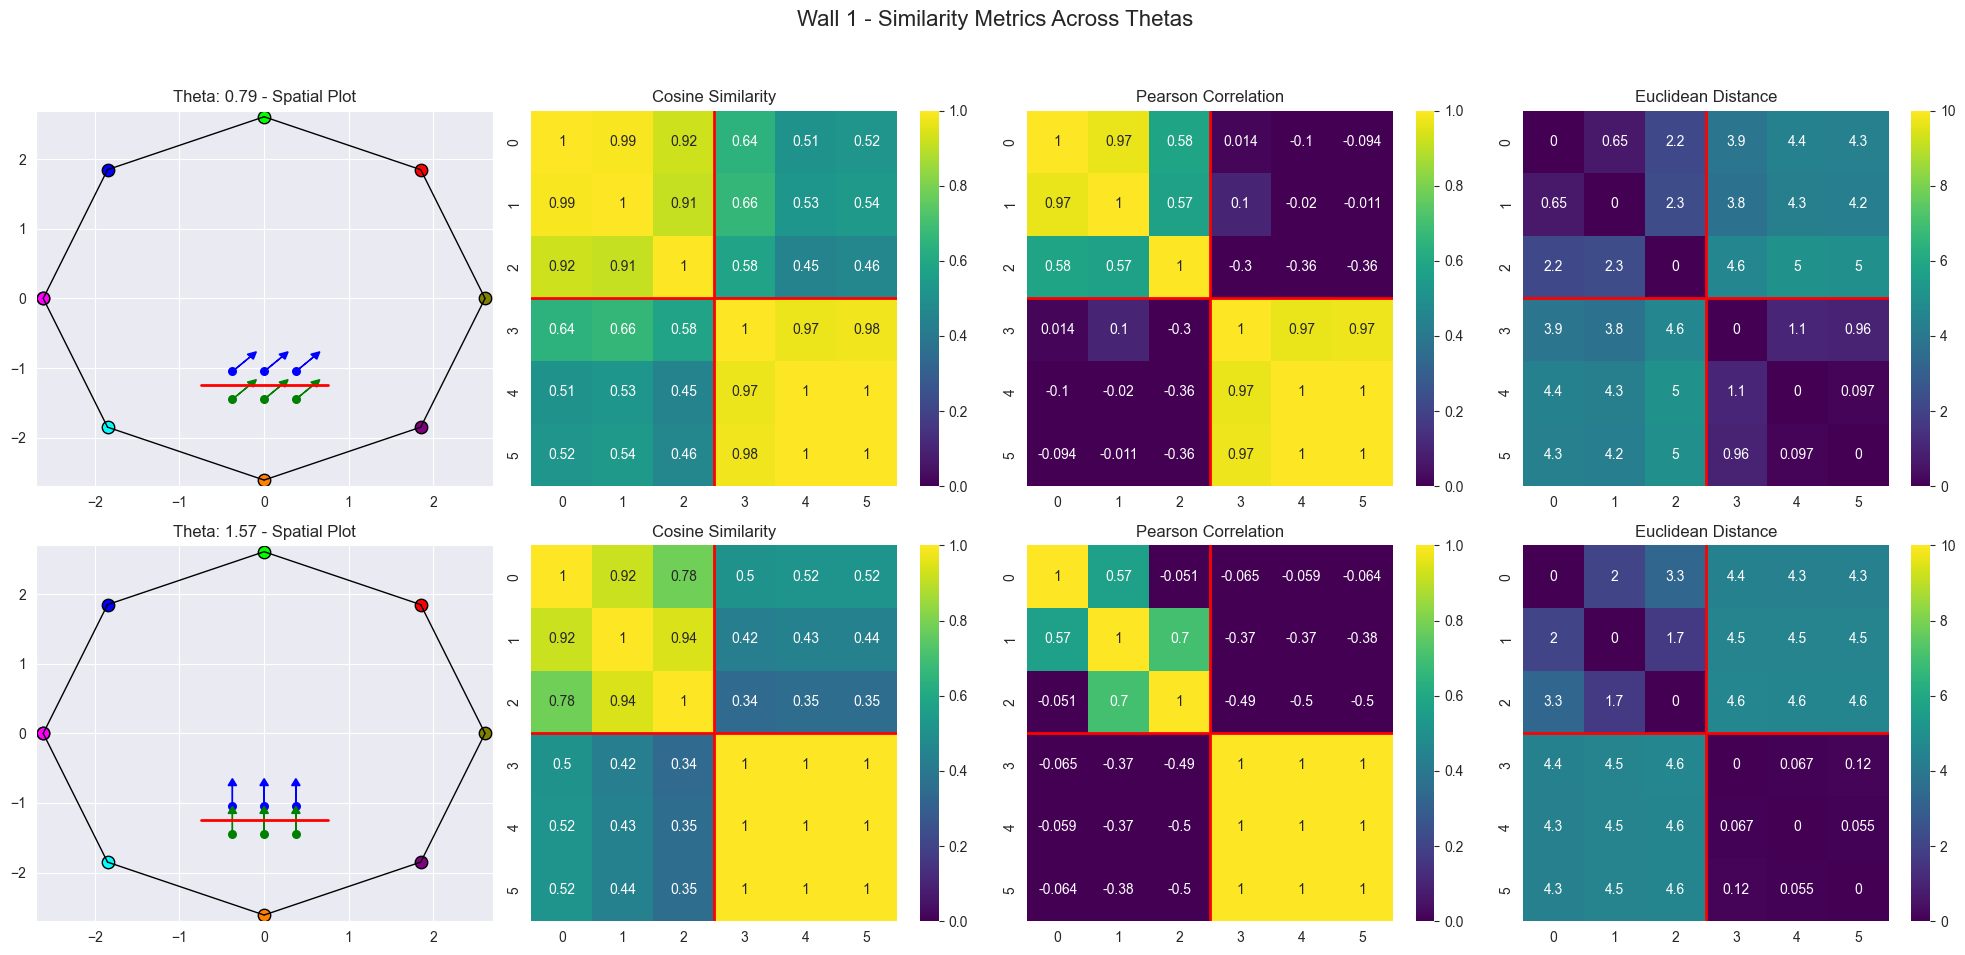

In [16]:
theta_list = [thetas[1],thetas[2]]
visualize_wall_similarity(LM8_added_grouped_data, pc_network_LM8, wall_num=1, theta_list=theta_list, landmarks=landmarks, walls=LM8_add_walls)

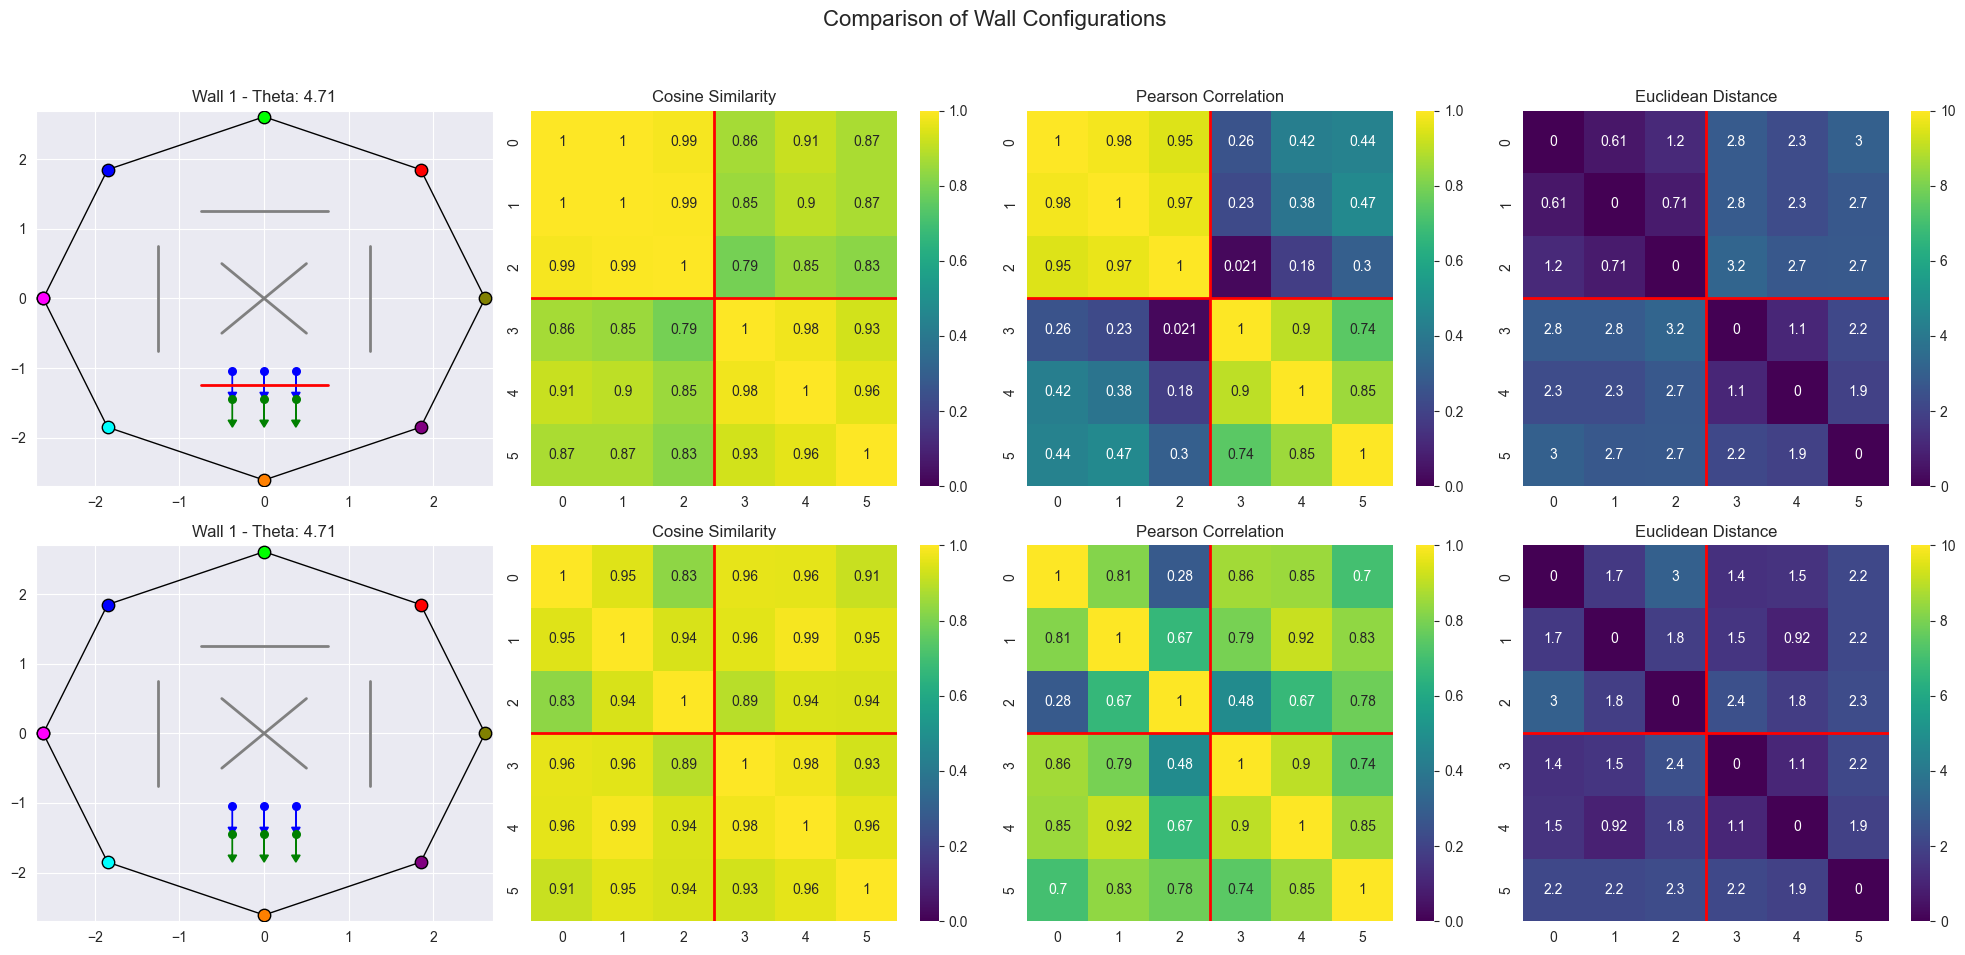

In [51]:
config_list = [
    [LMO8_grouped_data, pc_network_LMO8, 1, thetas[6], landmarks, LMO8_walls],
    [LMO8_removed_grouped_data, pc_network_LMO8, 1, thetas[6], landmarks, LMO8_remove_walls],
]
visualize_multiple_wall_similarity(config_list)

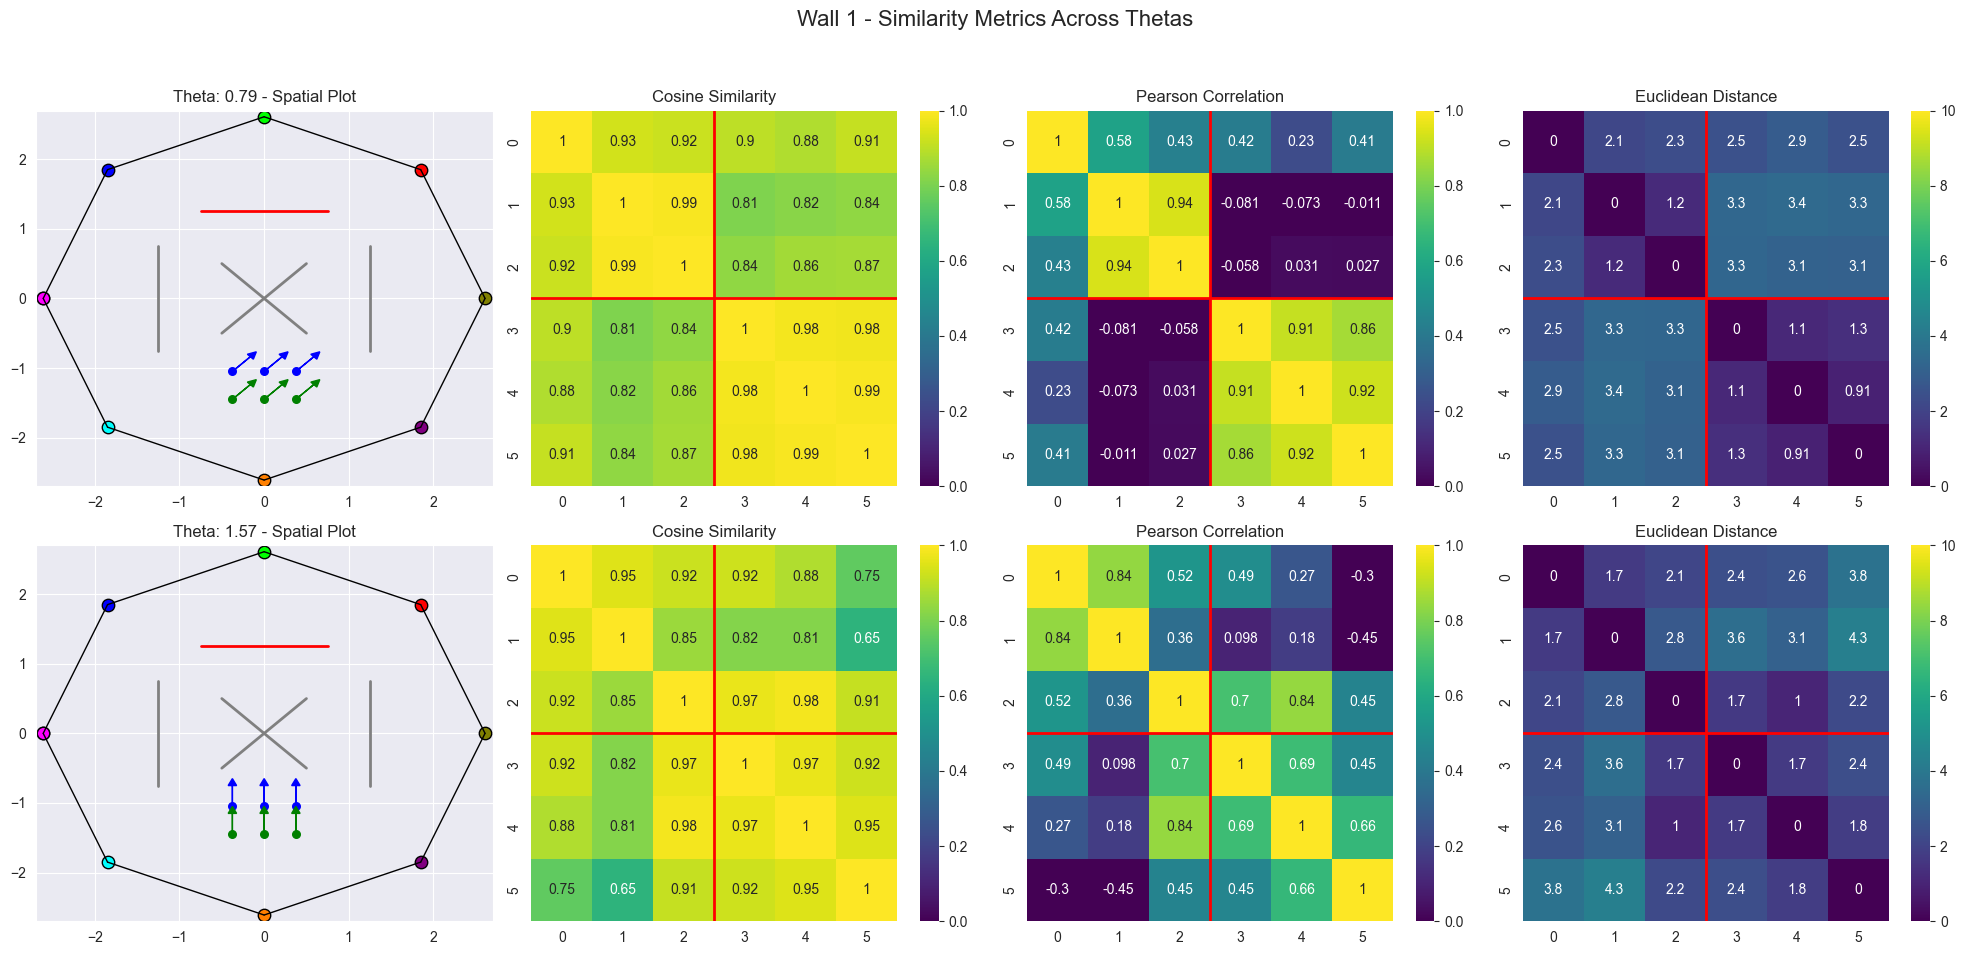

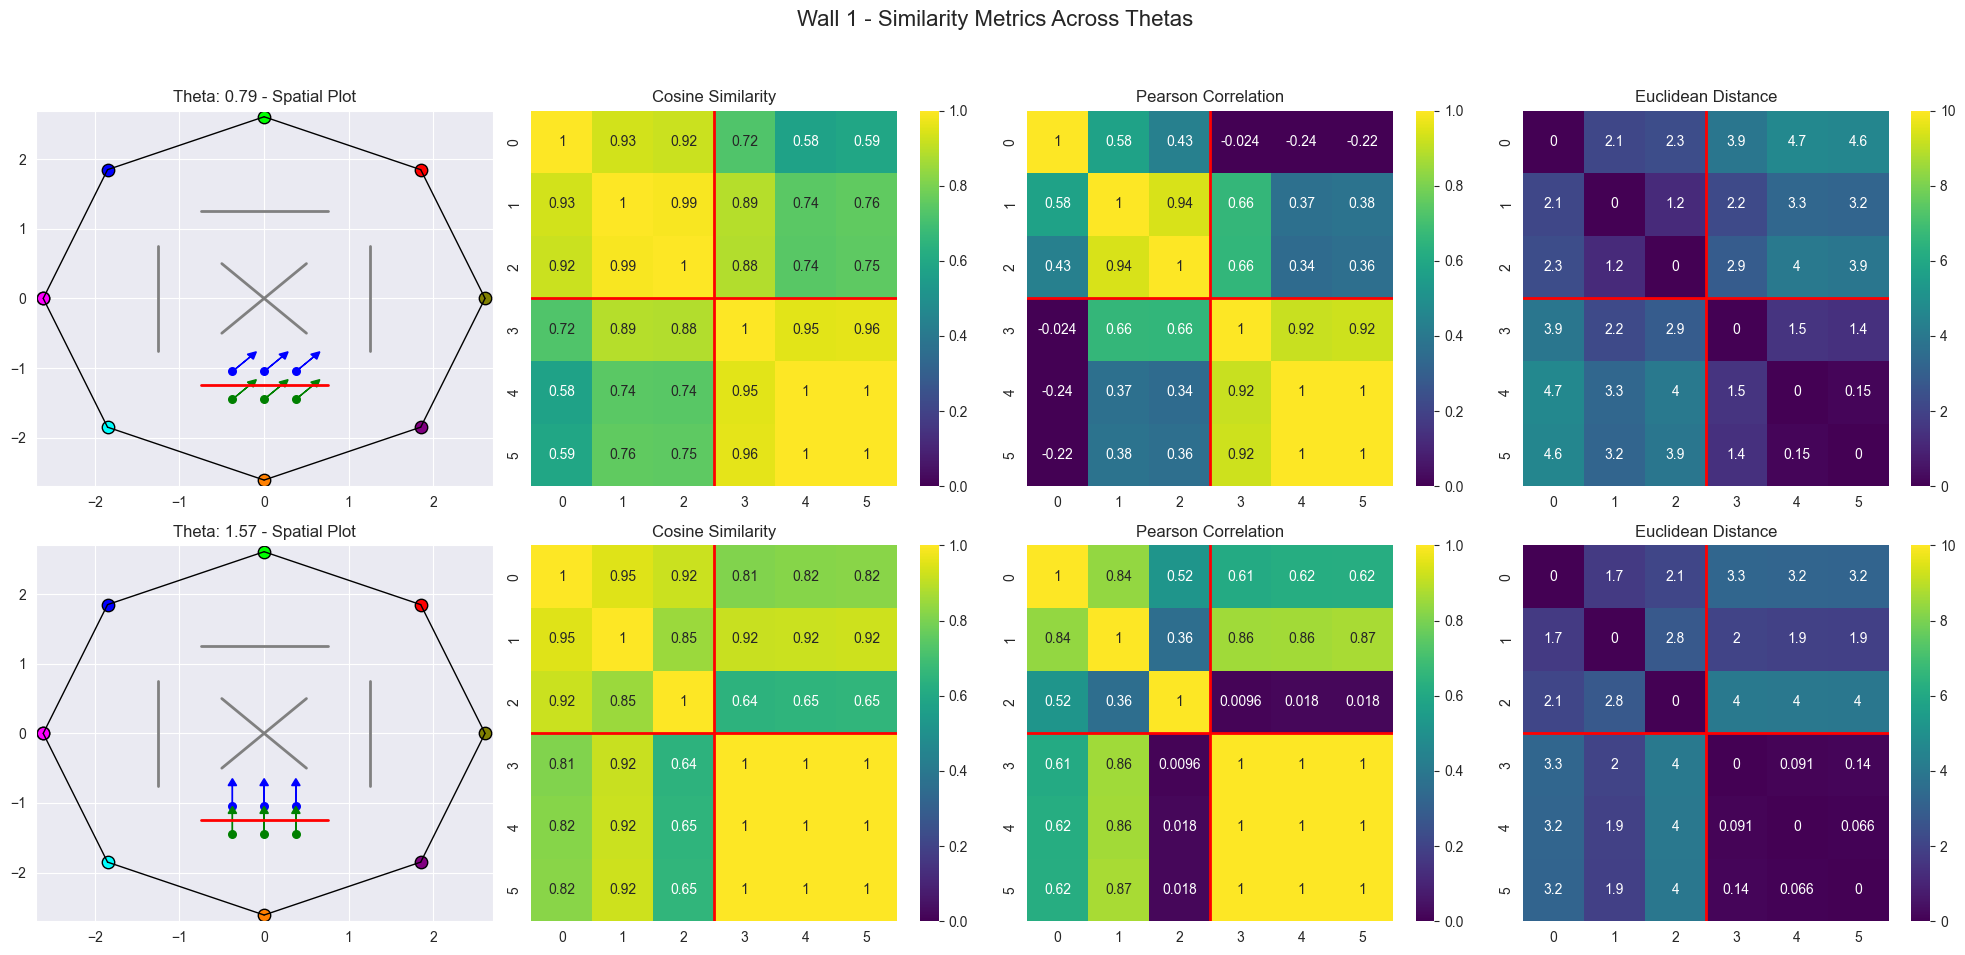

In [19]:
theta_list = [thetas[1],thetas[2]]
visualize_wall_similarity(LMO8_removed_grouped_data, pc_network_LMO8, wall_num=1, theta_list=theta_list, landmarks=landmarks, walls=LMO8_remove_walls)
visualize_wall_similarity(LMO8_grouped_data, pc_network_LMO8, wall_num=1, theta_list=theta_list, landmarks=landmarks, walls=LMO8_walls)

Calculating Similarity for Wall 1: 100%|██████████| 120/120 [00:07<00:00, 15.45it/s]


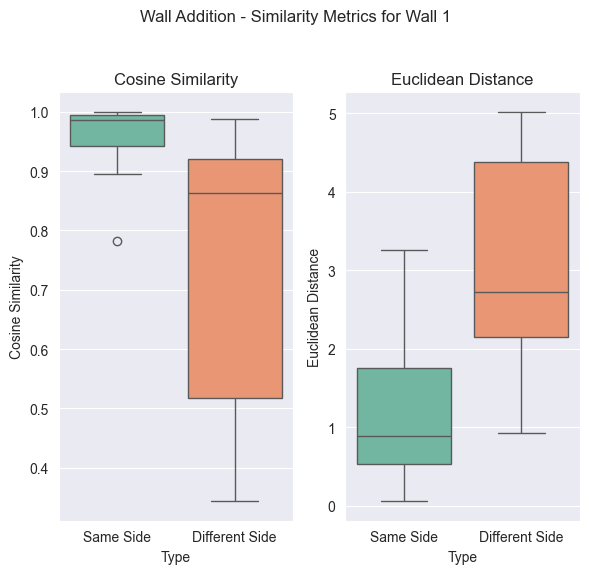

=== Statistical Results for Wall Addition ===
cosine_similarity:
  U-Statistic: 3134.0000
  p-value: 2.5550e-14
  Rank-Biserial Correlation: 0.8137
  Cohen's d: 1.4063

euclidean_distance:
  U-Statistic: 312.0000
  p-value: 1.6929e-14
  Rank-Biserial Correlation: -0.8194
  Cohen's d: -1.8564


Calculating Similarity for Wall 1: 100%|██████████| 120/120 [00:07<00:00, 15.06it/s]


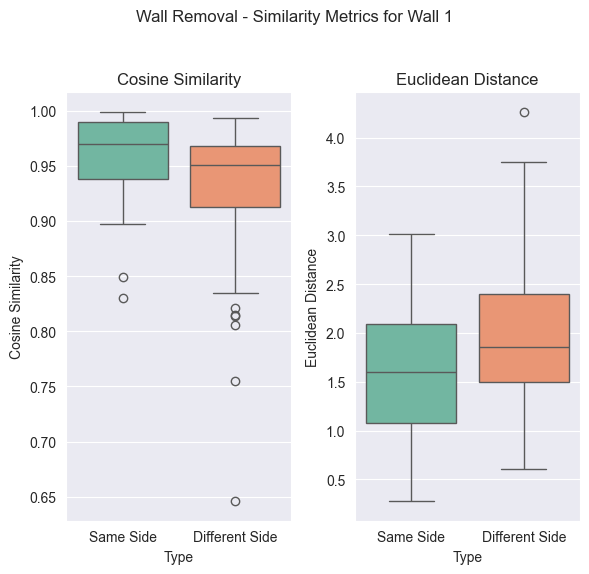

=== Statistical Results for Wall Removal ===
cosine_similarity:
  U-Statistic: 2304.0000
  p-value: 1.0250e-03
  Rank-Biserial Correlation: 0.3333
  Cohen's d: 0.5719

euclidean_distance:
  U-Statistic: 1186.0000
  p-value: 1.8614e-03
  Rank-Biserial Correlation: -0.3137
  Cohen's d: -0.6481


In [55]:
# Test Case 1: Wall Addition
same_side_metrics_add, diff_side_metrics_add = collect_wall_similarity_metrics(LM8_added_grouped_data, pc_network_LM8)
plot_wall_similarity_metrics(same_side_metrics_add, diff_side_metrics_add, "Wall Addition - Similarity Metrics for Wall 1")

# Perform effect size analysis for wall addition
results_add = compute_effect_sizes(same_side_metrics_add, diff_side_metrics_add)
print("=== Statistical Results for Wall Addition ===")
for key, value in results_add.items():
    print(f"{key}:")
    print(f"  U-Statistic: {value['u_statistic']:.4f}")
    print(f"  p-value: {value['p_value']:.4e}")
    print(f"  Rank-Biserial Correlation: {value['rank_biserial_corr']:.4f}")
    print(f"  Cohen's d: {value['cohen_d']:.4f}")
    print()

# Test Case 2: Wall Removal
same_side_metrics_remove, diff_side_metrics_remove = collect_wall_similarity_metrics(LMO8_removed_grouped_data, pc_network_LMO8)
plot_wall_similarity_metrics(same_side_metrics_remove, diff_side_metrics_remove, "Wall Removal - Similarity Metrics for Wall 1")

# Perform effect size analysis for wall removal
results_remove = compute_effect_sizes(same_side_metrics_remove, diff_side_metrics_remove)
print("=== Statistical Results for Wall Removal ===")
for key, value in results_remove.items():
    print(f"{key}:")
    print(f"  U-Statistic: {value['u_statistic']:.4f}")
    print(f"  p-value: {value['p_value']:.4e}")
    print(f"  Rank-Biserial Correlation: {value['rank_biserial_corr']:.4f}")
    print(f"  Cohen's d: {value['cohen_d']:.4f}")
    print()


In [57]:
# add wall
sampled_data = random.sample(same_side_metrics_add, 20)
same_sim_data = np.array([entry[0] for entry in sampled_data])
same_dist_data = np.array([entry[2] for entry in sampled_data])
sampled_data = random.sample(diff_side_metrics_add, 20)
diff_sim_data = np.array([entry[0] for entry in sampled_data])
diff_dist_data = np.array([entry[2] for entry in sampled_data])

t_statistic, p_value = stats.ttest_ind(same_sim_data,diff_sim_data)
print("\nIndependent two-sample t-test:")
print("t-statistic:", t_statistic)
print("p-value:", p_value)

t_statistic, p_value = stats.ttest_ind(same_dist_data, diff_dist_data)
print("\nIndependent two-sample t-test:")
print("t-statistic:", t_statistic)
print("p-value:", p_value)


Independent two-sample t-test:
t-statistic: 3.966109223549796
p-value: 0.00031222207075097476

Independent two-sample t-test:
t-statistic: -5.201250052092766
p-value: 7.069273788405576e-06


In [58]:
# Remove wall
sampled_data = random.sample(same_side_metrics_remove, 20)
same_sim_data = np.array([entry[0] for entry in sampled_data])
same_dist_data = np.array([entry[2] for entry in sampled_data])
sampled_data = random.sample(diff_side_metrics_remove, 20)
diff_sim_data = np.array([entry[0] for entry in sampled_data])
diff_dist_data = np.array([entry[2] for entry in sampled_data])

t_statistic, p_value = stats.ttest_ind(same_sim_data,diff_sim_data)
print("\nIndependent two-sample t-test:")
print("t-statistic:", t_statistic)
print("p-value:", p_value)

t_statistic, p_value = stats.ttest_ind(same_dist_data, diff_dist_data)
print("\nIndependent two-sample t-test:")
print("t-statistic:", t_statistic)
print("p-value:", p_value)


Independent two-sample t-test:
t-statistic: 1.866253341204437
p-value: 0.06973778272968431

Independent two-sample t-test:
t-statistic: -1.595808827701707
p-value: 0.11881570744447094


In [35]:
# Test Case 1: Wall Addition
paired_metrics_add = collect_matching_pairs(LM8_grouped_data, LM8_added_grouped_data, pc_network_LM8)
results_add = compute_effect_sizes_paired(paired_metrics_add)
print("=== Statistical Results for Wall Addition ===")
for key, value in results_add.items():
    print(f"{key}:")
    print(f"  U-Statistic: {value['u_statistic']:.4f}")
    print(f"  p-value: {value['p_value']:.4e}")
    print(f"  Rank-Biserial Correlation: {value['rank_biserial_corr']:.4f}")
    print(f"  Cohen's d: {value['cohen_d']:.4f}")
    print()

# Test Case 2: Wall Removal
paired_metrics_remove = collect_matching_pairs(LMO8_grouped_data, LMO8_removed_grouped_data, pc_network_LMO8)
results_remove = compute_effect_sizes_paired(paired_metrics_remove)
print("=== Statistical Results for Wall Removal ===")
for key, value in results_remove.items():
    print(f"{key}:")
    print(f"  U-Statistic: {value['u_statistic']:.4f}")
    print(f"  p-value: {value['p_value']:.4e}")
    print(f"  Rank-Biserial Correlation: {value['rank_biserial_corr']:.4f}")
    print(f"  Cohen's d: {value['cohen_d']:.4f}")
    print()


=== Statistical Results for Wall Addition ===
cosine_similarity:
  U-Statistic: 1112.0000
  p-value: 6.1788e-01
  Rank-Biserial Correlation: -0.0347
  Cohen's d: -0.5800

euclidean_distance:
  U-Statistic: 1192.0000
  p-value: 6.1788e-01
  Rank-Biserial Correlation: 0.0347
  Cohen's d: 0.5800


=== Statistical Results for Wall Removal ===
cosine_similarity:
  U-Statistic: 1096.0000
  p-value: 6.6217e-01
  Rank-Biserial Correlation: -0.0486
  Cohen's d: -0.5763

euclidean_distance:
  U-Statistic: 1208.0000
  p-value: 6.6217e-01
  Rank-Biserial Correlation: 0.0486
  Cohen's d: 0.5763


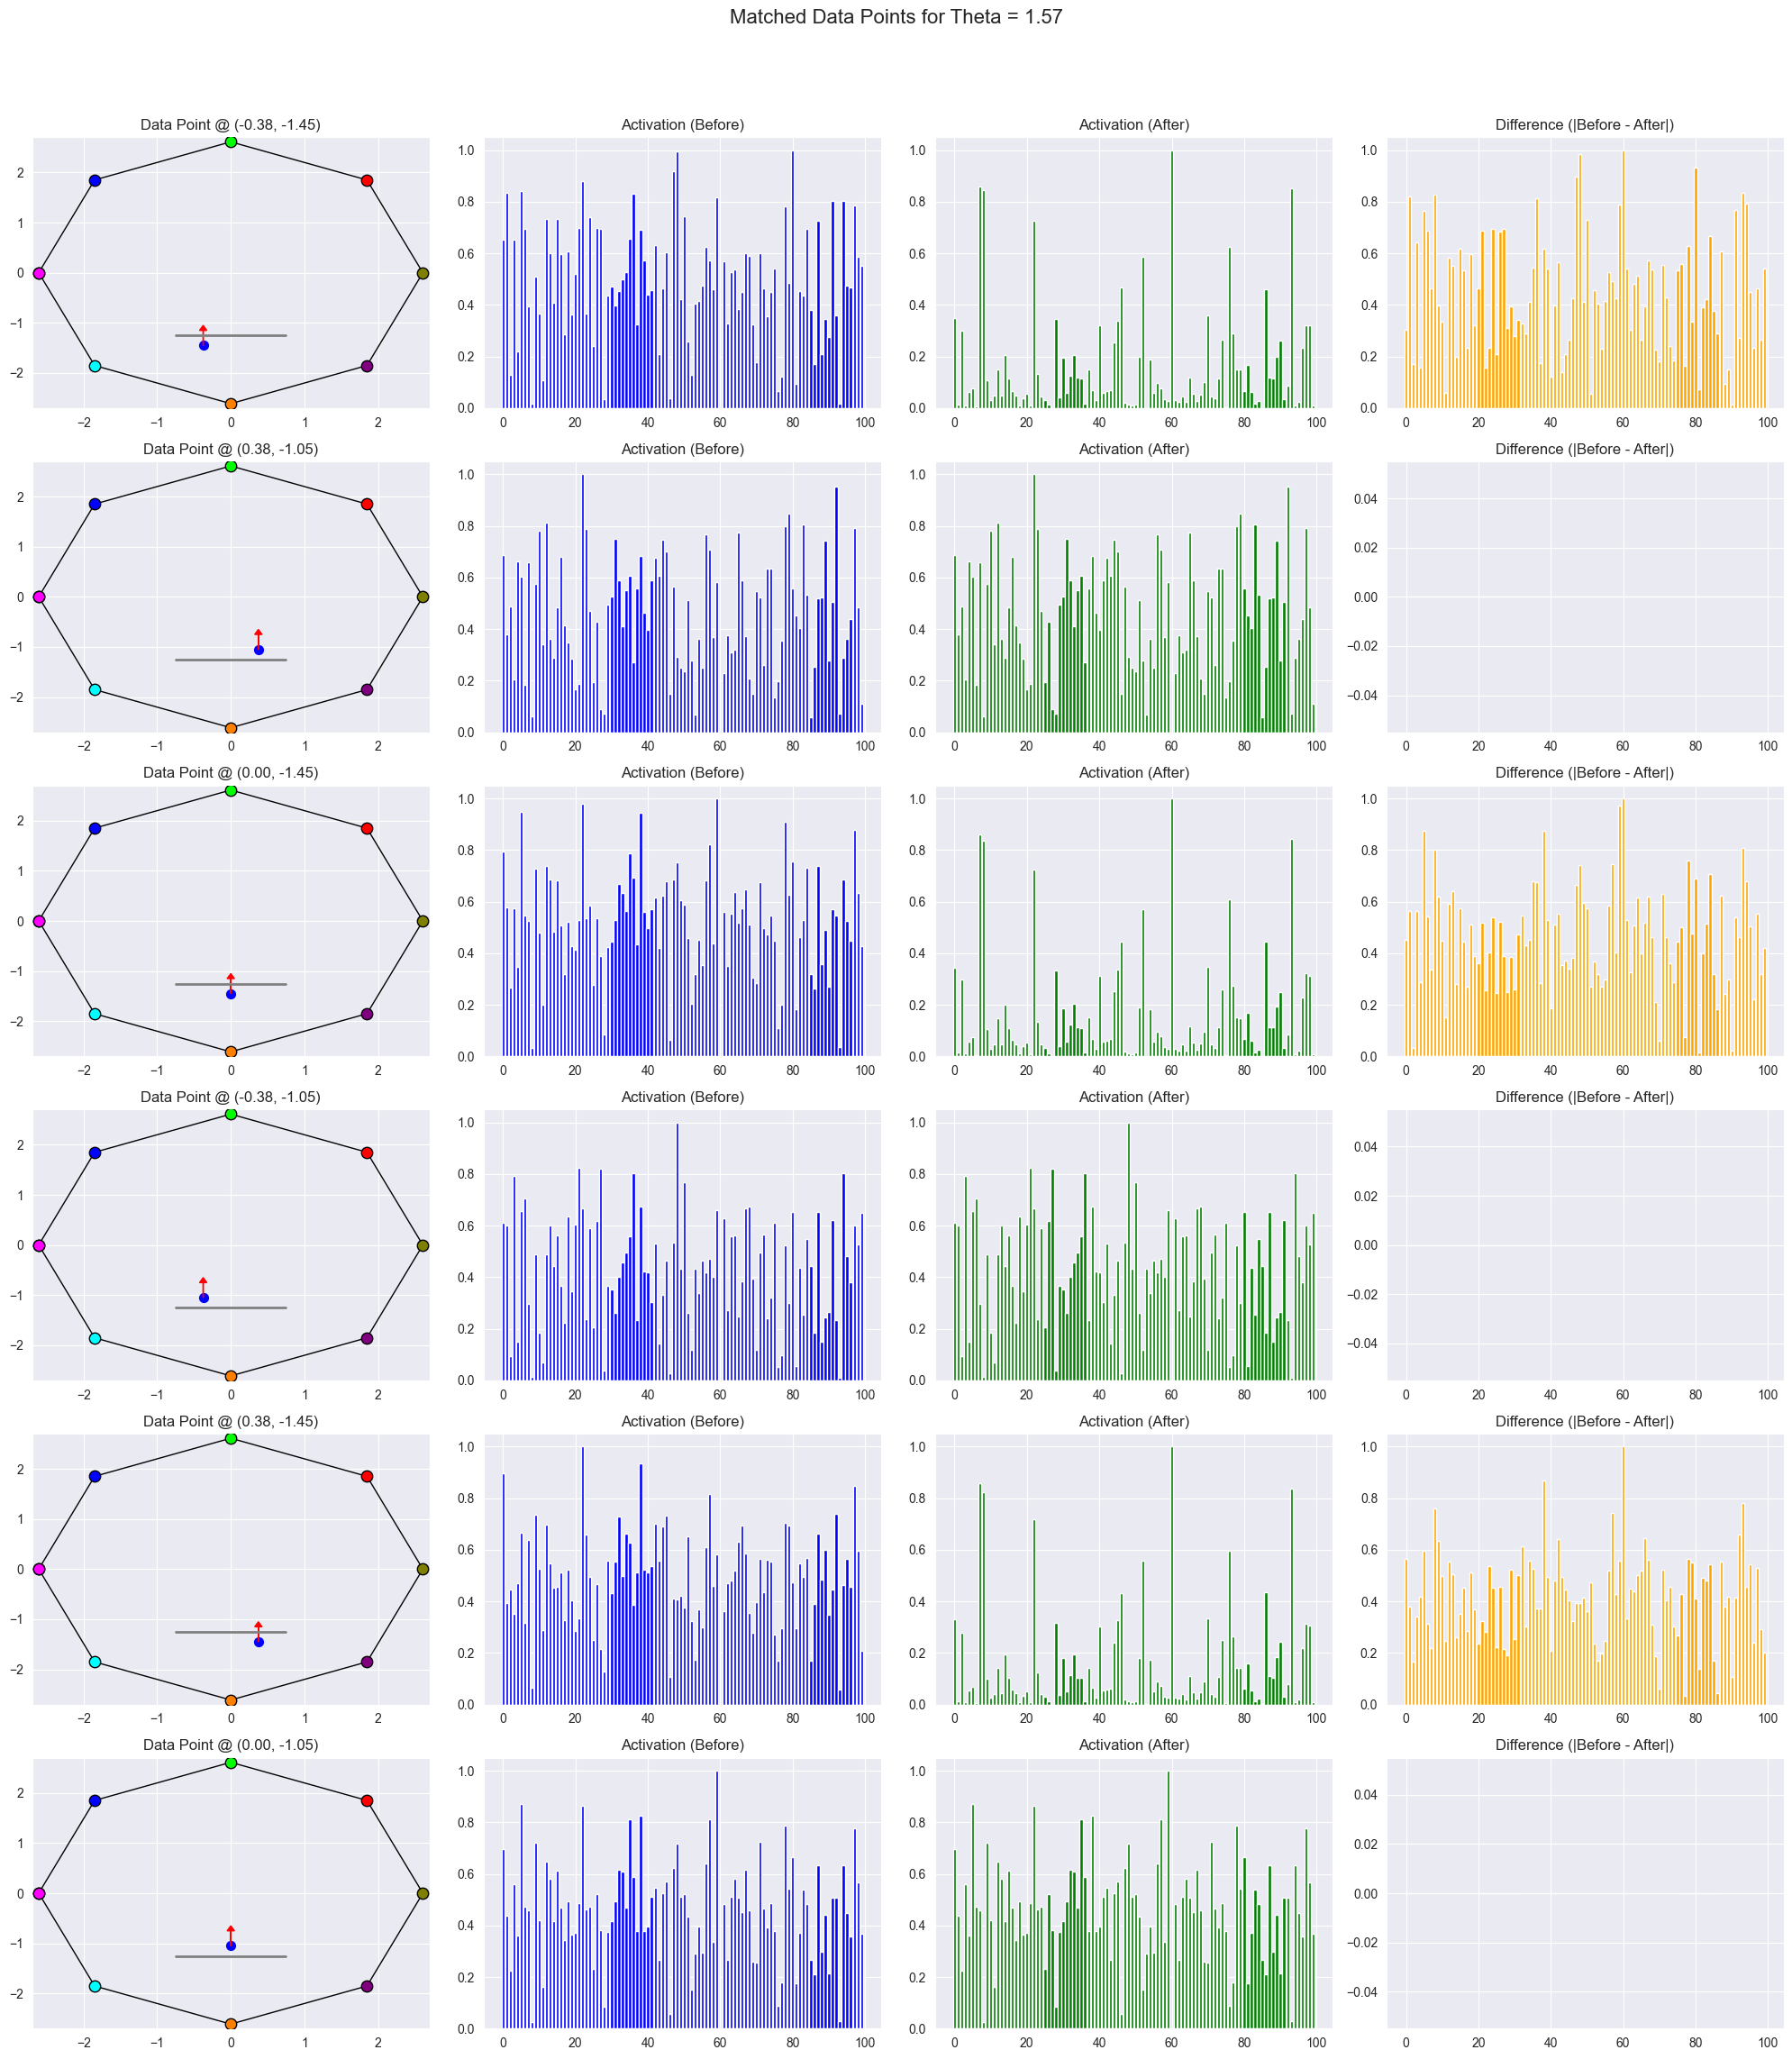

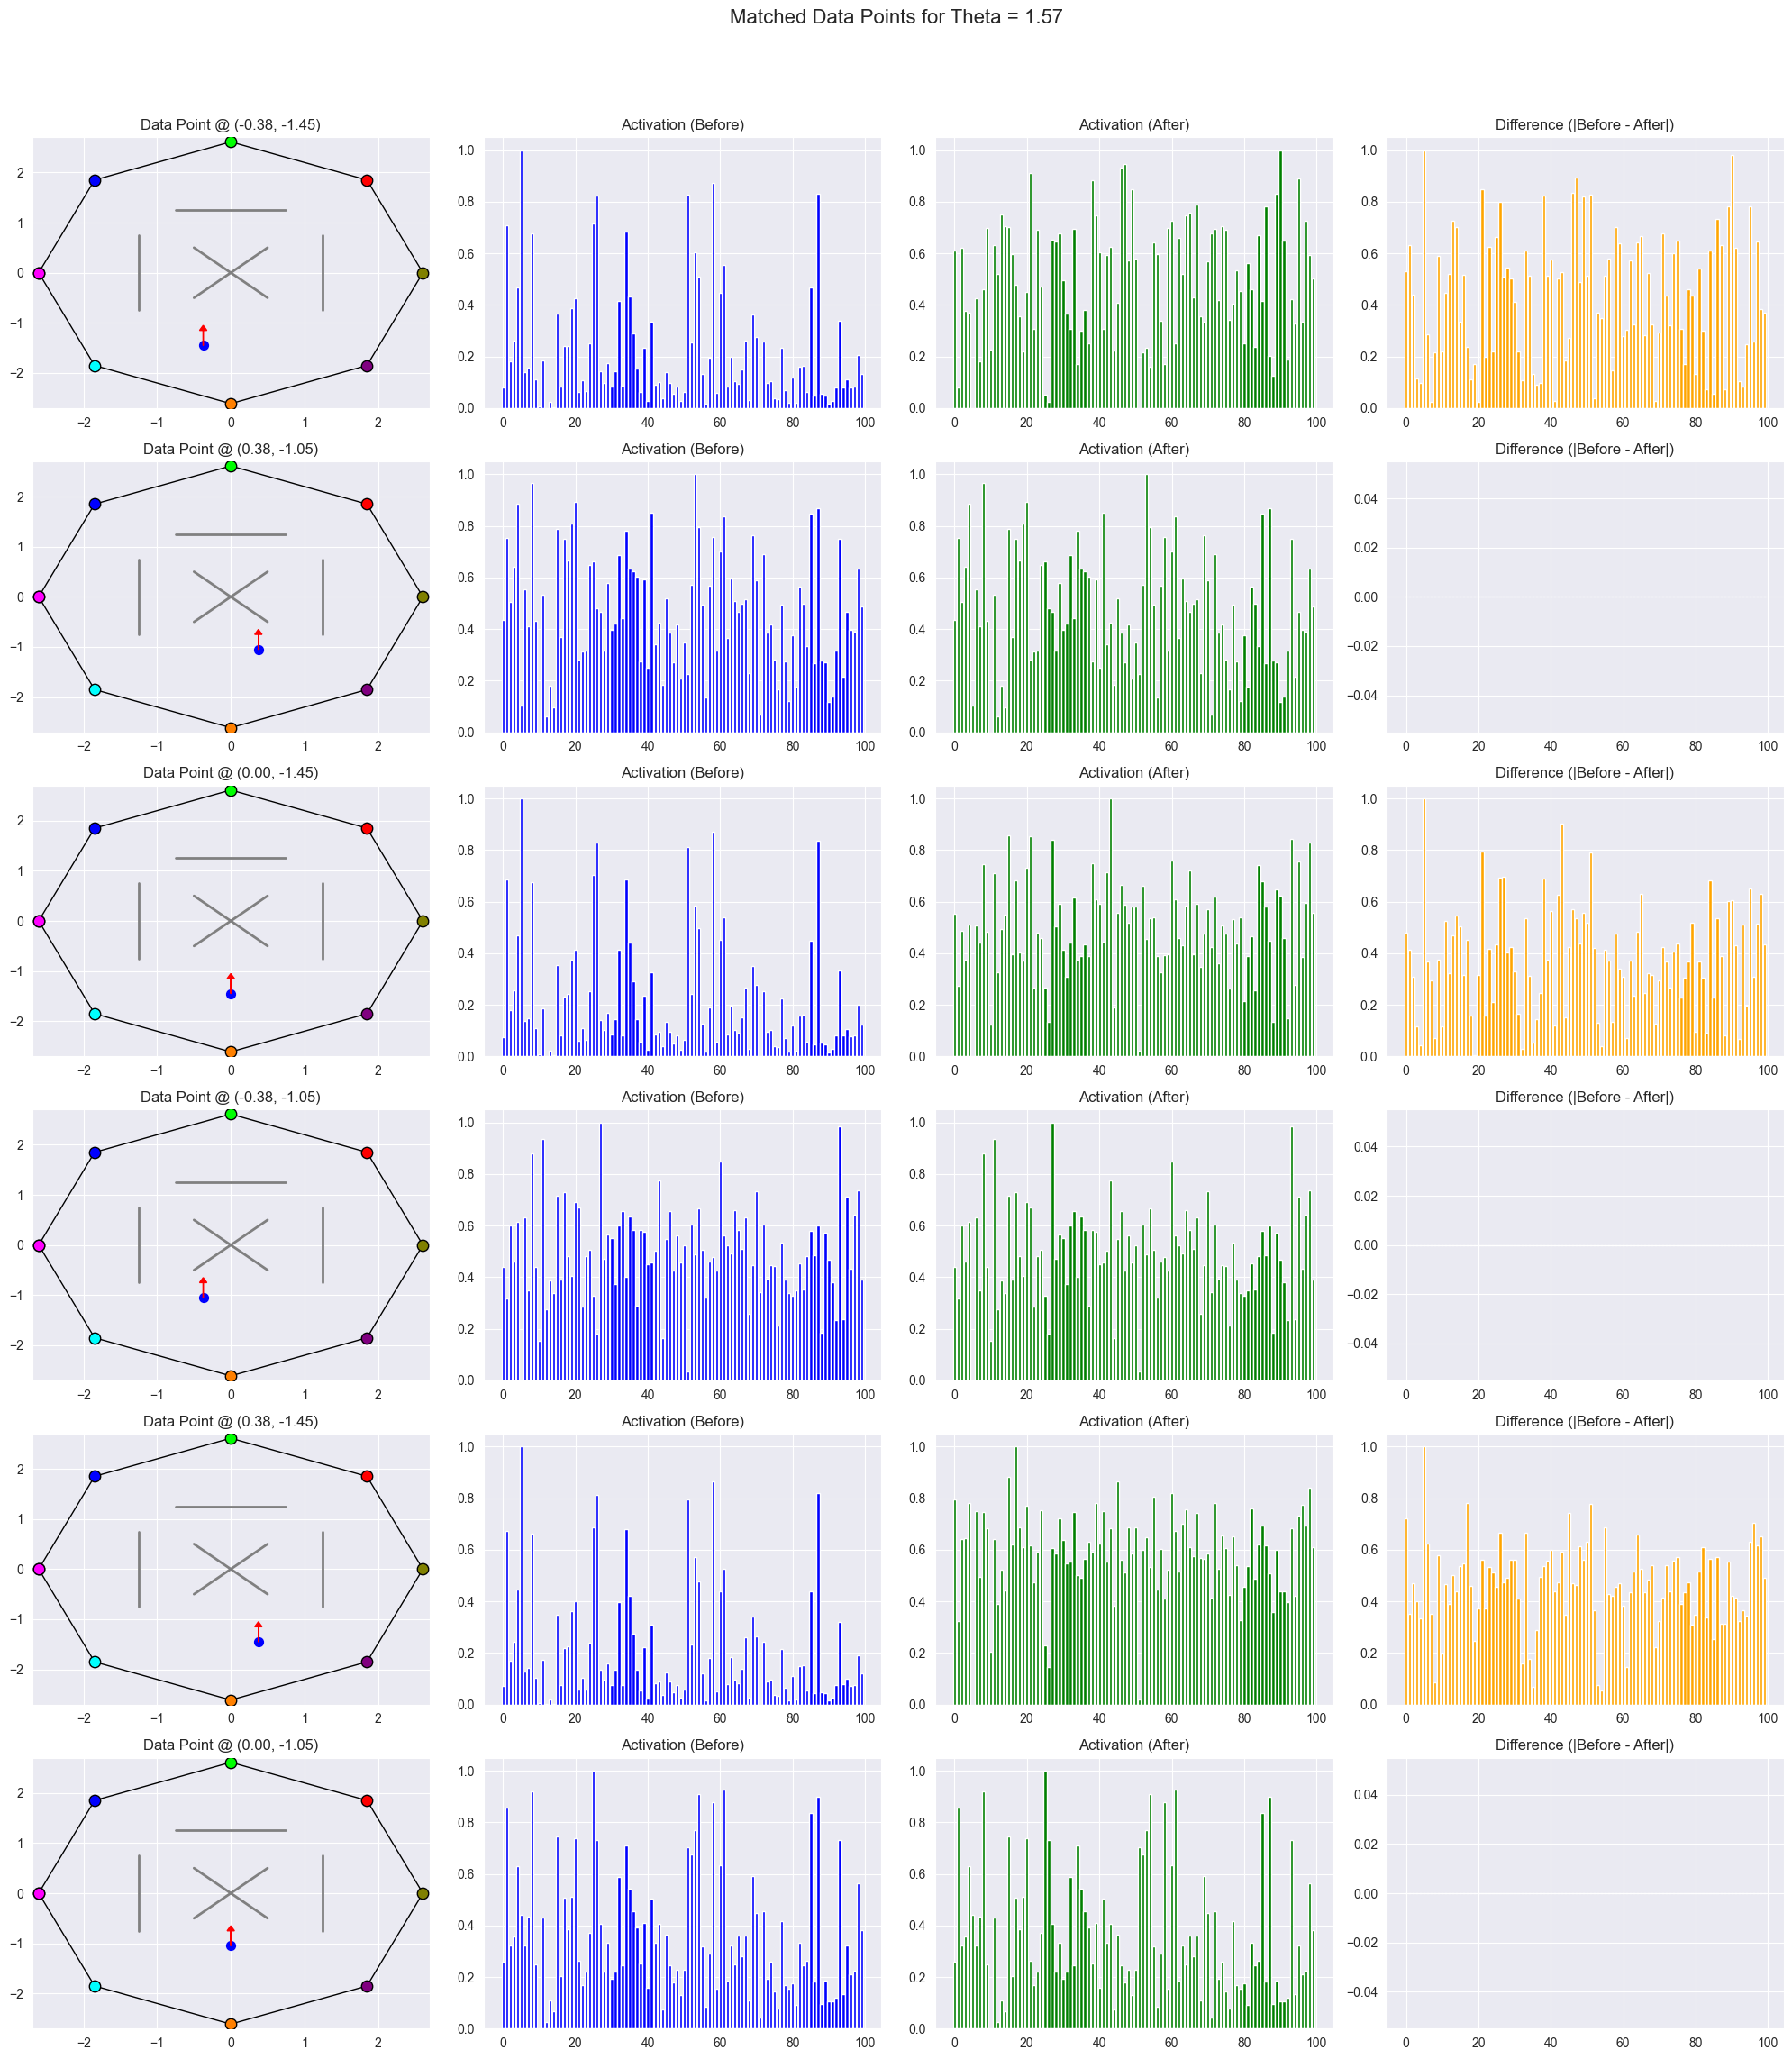

In [45]:
# Wall Addition (Using PC network trained in open-world)
plot_matching_pairs(LM8_grouped_data, LM8_added_grouped_data, pc_network_LM8, 
                    theta=thetas[2], landmarks=landmarks, walls=LM8_add_walls)

# Wall Removal (Using PC network trained in full-world)
plot_matching_pairs(LMO8_grouped_data, LMO8_removed_grouped_data, pc_network_LMO8, 
                    theta=thetas[2], landmarks=landmarks, walls=LMO8_remove_walls)
